In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pyreadr

# to plot interaction networks of As and Ss; must be version >= 3.0 due to
# an update to MatPlotLib
from scipy.stats import nbinom
import statsmodels.api as sm
from statsmodels.formula.api import glm
import anndata as ad
import random
from scipy.sparse import coo_matrix, csc_matrix

PAM50genes = [
    "EGFR",    "CDH3",
    "PHGDH",    "ACTR3B",
    "FOXC1",    "MIA",
    "MYC",    "FGFR4",
    "MDM2",    "MLPH",
    "KRT14",    "BCL2",
    "SFRP1",    "KRT5",
    "KRT17",    "SLC39A6",
    "ESR1",    "CXXC5",
    "BLVRA",    "FOXA1",
    "GPR160",    "NAT1",
    "MAPT",    "PGR",
    "BAG1",    "TMEM45B",
    "ERBB2",    "GRB7",
    "MMP11",    "CDC20",
    "MKI67",    "CCNE1",
    "CENPF",    "NUF2",
    "EXO1",    "KIF2C",
    "ORC6",    "ANLN",
    "CDC6",    "RRM2",
    "UBE2T",    "NDC80",
    "CEP55",    "MELK",
    "TYMS",    "CCNB1",
    "BIRC5",    "MYBL2",
    "PTTG1",    "UBE2C"
]

# output folder name
output_folder_name = "dataset_omega_subtype_5"

This version of the PAM50 dataset creating program (where it includes a stroma-like sample with its own set of rules), we will be excluing Normal-like

First we need to compute the omega values

In [2]:
# stickbreaking
# code added to avoid negative numbers and set a minimum of 1e-8 to make sure each gene has some counts

def generate_frequency_vector(number_probs, sticknames):
    epsilon = 1e-8  # Small epsilon to ensure the number is strictly between l and r
    total_mass = 1.0  # Total stick length
    # Allocate a portion of the mass to the first 50 genes
    total_mass_for_first50 = 0.2  # Adjust this fraction as needed
    
    num_equal_pieces = min(50, number_probs)  # In case number_probs < 50
    
    # Base size for each of the first 50 pieces
    base_piece_size = total_mass_for_first50 / num_equal_pieces
    
    freq = []

    # Generate frequencies for the first 50 genes with wiggle
    for i in range(num_equal_pieces):
        # Add a small wiggle to the base size
        wiggle_fraction = 0.1  # Adjust the wiggle intensity (10% here)
        wiggle = base_piece_size * wiggle_fraction * (random.uniform(-1, 1))
        piece_of_stick = base_piece_size + wiggle
        
        # Ensure the piece size stays within reasonable bounds
        min_piece_size = base_piece_size * (1 - wiggle_fraction)
        max_piece_size = base_piece_size * (1 + wiggle_fraction)
        piece_of_stick = max(min_piece_size, min(max_piece_size, piece_of_stick))
        
        freq.append(piece_of_stick)
    
    # Adjust the frequencies to sum up to the allocated total mass for the first 50 genes
    total_first50 = sum(freq)
    scaling_factor = total_mass_for_first50 / total_first50
    freq = [f * scaling_factor for f in freq]
    
    # Remaining mass to be allocated
    remaining_mass = total_mass - total_mass_for_first50
    remaining_probs = number_probs - num_equal_pieces
    
    if remaining_probs > 0 and remaining_mass > 0:
        # Start with a stick of length equal to the remaining mass
        L = [[0, remaining_mass]]
    
        for k in range(remaining_probs - 1):  # Since we already have one interval
            interval_index = random.randint(0, len(L) - 1)
            l, r = L[interval_index]
    
            number = random.uniform(l + epsilon, r - epsilon)
    
            new_intervals = [[l, number], [number, r]]
            L.pop(interval_index)
            L.extend(new_intervals)
    
        # Compute piece_of_stick for remaining intervals
        for l in L:
            piece_of_stick = l[1] - l[0]
            if piece_of_stick < epsilon:
                piece_of_stick = epsilon
            freq.append(piece_of_stick)
    elif remaining_probs > 0 and remaining_mass <= 0:
        # Can't allocate negative or zero mass; assign minimal mass
        piece_of_stick = epsilon
        for _ in range(remaining_probs):
            freq.append(piece_of_stick)
    else:
        # No remaining probabilities
        pass
    
    # Map frequencies to sticknames
    named_values = list(zip(sticknames, freq))
    return named_values

In [ ]:
path_to_data = "/path/to/datasets/"
data_folder = "dcis"
dataset = "/train_validation/expression_counts.Jan2023_1_2_and_2_2_19K.tau_1.h5ad"


anndata_test = ad.read_h5ad(path_to_data + data_folder + dataset)
expr_matrix = anndata_test.X
gene_order = anndata_test.var['gene']

subtype_info = anndata_test.obs['subtype']

# checking if matrix given is a tensor or a numpy array
if isinstance(expr_matrix, np.ndarray):
    cleaned_matrix = np.nan_to_num(expr_matrix)
else:
    cleaned_matrix = np.nan_to_num(expr_matrix.detach().cpu().numpy())

In [ ]:
# Gene Name Conversion
file = "/path/to/metadata/ensemble_to_refseq_gene_name_table.rds"

gene_converter = pyreadr.read_r(file)
gene_converter = gene_converter[None]

# only do this step if gene names are all Ensemble genes
all_start_with_ENSG = all(gene_id.startswith('ENSG') for gene_id in gene_order)

if (all_start_with_ENSG):
    filtered_df = gene_converter[gene_converter['gene_id'].isin(gene_order)]
    gene_mapping = pd.Series(filtered_df.gene_name.values,index=filtered_df.gene_id).to_dict()

    gene_ids_list = [gene_mapping[gene_name] for gene_name in gene_order if gene_name in gene_mapping]

    gene_order = gene_ids_list


# normalize library size
anndata_test.obs['library_size'] = anndata_test.X.sum(axis=1)

In [5]:

# which gene_order are in PAM50_genes; no repeat genes in AnnData tables
if gene_order is not None:
    gene_indices = {gene: index for index, gene in enumerate(gene_order)}
    gene_match = [
        gene_indices[gene] if gene in gene_indices else None for gene in PAM50genes
    ]

    indices = [index for index in gene_match if index is not None]

    present_pam50 = [
        gene for gene, idx in zip(PAM50genes, gene_match) if idx is not None
    ]

    cleaned_matrix = cleaned_matrix[:, indices]
    print("PAM50 Genes Found: ", len(cleaned_matrix[0]))

    missing_pam50 = [
        gene for gene, idx in zip(PAM50genes, gene_match) if idx is None
    ]

    # Print missing PAM50 genes
    print("Missing PAM50 Genes: ", missing_pam50)
else:
    print("Missing names of genes (required)")

# add 50 non-informative genes
mu = 100
theta = 1

# Calculating n and p
n = theta
p = n / (n + mu)

# Generate new data from Negative Binomial distribution
# Size is (229, 50) to match 50 new genes for 229 samples
new_data = np.random.negative_binomial(n, p, size=(229, 50))

# Combine existing data with the new data
expanded_data = np.concatenate((cleaned_matrix, new_data), axis=1)

# and expand the gene names
for i in range(1, 51):
    gene_name = f"gene_{i}"
    present_pam50.append(gene_name)

# I want to normalize over all samples

df = pd.DataFrame(expanded_data)

pam50_lib_size = df.sum(axis=1)

##### THIS IS WHERE MU IS CHANGED FROM COUNTS TO OMEGA
cleaned_matrix = (expanded_data / pam50_lib_size.values[:, None])



#### USE THIS OPTION FOR NORMALIZED LIBRARY COUNTS
#cleaned_matrix = (cleaned_matrix / pam50_lib_size.values[:, None])*100000

PAM50 Genes Found:  50
Missing PAM50 Genes:  []


In [ ]:
# now lets draw the PAM50 distribution on a per-subtype basis
count = 0
df_final = pd.DataFrame(columns=['Gene', 'Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"])

for gene in present_pam50:
        gene_data = cleaned_matrix[:, count].flatten()
        count = count + 1
        
        # we split data by subtype
        data = pd.DataFrame({
            'Numbers': gene_data,
            'Categories': subtype_info
        })
        grouped = data.groupby('Categories')['Numbers'].apply(list)
        for subtype, subtype_expression in grouped.items():
            if (subtype == "NaN" or subtype == "Normal"):
                continue

            n = len(subtype_expression)
            trim_percent = 0
            elements_to_trim = int(np.floor(trim_percent / 100.0 * n))  
            sorted_data = np.sort(subtype_expression)
            
            if (elements_to_trim > 0):
               print (elements_to_trim)
               subtype_expression = sorted_data[elements_to_trim:-elements_to_trim]

            if(gene == "ERBB2"):
                 print(subtype)
                 print(subtype_expression)

            # calculate NB parameters
            mu = np.mean(subtype_expression)
            variance = np.var(subtype_expression, ddof=1)

            # Calculate dispersion parameter (theta) using method of moments
            theta = mu**2 / (variance - mu)

            # somehow the r paramater is computed the same way
            r = mu**2 / (variance - mu)
            p = r / (r + mu)
            
            x = np.arange(0, np.max(subtype_expression) + 1)  # Range of values
            pmf = nbinom.pmf(x, r, p)

            # getting a summary description of the NB parameters using statsmodels.api
            X = np.ones_like(subtype_expression)
            model = sm.NegativeBinomial(subtype_expression, X)
            results = model.fit(disp=0)

            p_values = results.pvalues
            coeffs = results.params


            df = pd.DataFrame({
                'Parameter': ['Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"],
                'Value': [mu, variance, round(theta, 5), round(p, 5), round(r, 5), round(coeffs[0], 4), round(p_values[0], 5), round(coeffs[1],4), round(p_values[1],5)]
            })
            new_row = {
                'Gene': gene,
                'Subtype': subtype, 
                'Mean(mu)': mu, 
                'Variance': variance, 
                'Dispersion': round(theta, 5),
                "p": round(p, 10),
                "r": round(r, 10),
                "const_coeff": round(coeffs[0], 4), 
                "const_pval": round(p_values[0], 4), 
                "alpha_const": round(coeffs[1],4), 
                "alpha_pval": round(p_values[1],4),
            
            
            }

            df_final = df_final.append(new_row, ignore_index=True)

In [11]:
print(df_final[df_final['Gene'] == 'gene_3'])

# Print the filtered DataFrame)

gene = df_final['Gene']
mu = df_final['Mean(mu)']

# check to make sure mu (which is essentially omega in this context) equals 1
sum_mean_luma = df_final.loc[df_final['Subtype'] == 'LumA', 'Mean(mu)'].sum()

print(f"Sum of 'Mean' for Subtype 'LumA': {sum_mean_luma}")


       Gene  Mean(mu)  Variance Dispersion            p         r const_coeff  \
208  gene_3  0.000701  0.000001    -0.0007   701.461031 -0.000702     -7.2632   
209  gene_3  0.000308       0.0   -0.00031  2278.897129 -0.000308     -8.0854   
210  gene_3   0.00042       0.0   -0.00042  2003.556778 -0.000421     -7.7744   
211  gene_3  0.000504       0.0    -0.0005  3938.710223 -0.000504     -7.5929   

    const_pval alpha_const alpha_pval Subtype  
208     0.2422      0.0227     0.9988   Basal  
209      0.408      0.0591      0.998    Her2  
210     0.2459      0.0348     0.9983    LumA  
211     0.2281      0.0293     0.9985    LumB  
Sum of 'Mean' for Subtype 'LumA': 1.0000000000000004


In [9]:
vector_of_omegas = df_final.groupby('Subtype').apply(lambda x: list(zip(x['Gene'], x['Mean(mu)']))).to_dict()

# Print the vectors for each subtype
for subtype, vector in vector_of_omegas.items():
    print(f"Subtype {subtype}: {vector}")

Subtype Basal: [('EGFR', 0.061812162934495), ('CDH3', 0.021094665495370375), ('PHGDH', 0.01991089582379304), ('ACTR3B', 0.005957376100369775), ('FOXC1', 0.01609764609259436), ('MIA', 4.993294532583558e-05), ('MYC', 0.025540499822462245), ('FGFR4', 0.007290519390951657), ('MDM2', 0.032670538272157455), ('MLPH', 0.0825757417343723), ('KRT14', 0.05339907030610978), ('BCL2', 0.006894639508958135), ('SFRP1', 0.020447973050986504), ('KRT5', 0.040880043489809115), ('KRT17', 0.04958464898560787), ('SLC39A6', 0.04430945617997424), ('ESR1', 0.05249022777000183), ('CXXC5', 0.015752641192727027), ('BLVRA', 0.0061670233123380614), ('FOXA1', 0.03060486195865498), ('GPR160', 0.0016414045375650506), ('NAT1', 0.0012455150323774746), ('MAPT', 0.014113679506139159), ('PGR', 0.014250503631958417), ('BAG1', 0.018959794454585323), ('TMEM45B', 0.0013178598563283862), ('ERBB2', 0.17403354664778597), ('GRB7', 0.015350797560936335), ('MMP11', 0.0031713328551347475), ('CDC20', 0.002887423936277925), ('MKI67', 0.

In [10]:
l = 100000.0       # Replace with your actual l value
theta = 1

g_values = []
poisson_values = []

pam50s = ['Basal', 'Her2', 'LumA', 'LumB']

for subtype in pam50s:
    print(subtype)
    gene_order = []
    for gene, mean_omega in vector_of_omegas[subtype]:
        # print(gene, mean)
        # Generate a gamma random variable with shape = s_i and scale = theta
        g_i = np.random.gamma(shape=mean_omega, scale=theta)
        
        
        # Store the rounded g_i
        g_values.append(g_i)
        
        # Compute lambda for Poisson
        lambda_i = l * g_i
        
        # Generate a Poisson random variable with parameter lambda_i
        poisson_i = np.random.poisson(lambda_i)
        
        # Store the Poisson value
        poisson_values.append(poisson_i)

        gene_order.append(gene)


Basal
Her2
LumA
LumB


In [29]:
patients_to_generate = 1000
subtype_prob = [0.25, 0.25, 0.25, 0.25]
selected_indices_train = np.random.choice(a=[0, 1, 2, 3], p=subtype_prob, size=patients_to_generate)

In [11]:
pam50s = ['Basal', 'Her2', 'LumA', 'LumB']

l = 100000      # Replace with your actual l value
theta = 5

pd_columns = gene_order.copy()
pd_columns.insert(0, "Subtype")

df = pd.DataFrame(columns=pd_columns)
df_val = pd.DataFrame(columns=pd_columns)

for i, subtype in enumerate(pam50s):

    pats_to_generate = np.sum(selected_indices_train == i)

    for i in range(pats_to_generate):
        poisson_values, poisson_values_val = [], []

        for gene, mean_omega in vector_of_omegas[subtype]:
            # print(gene, mean_omega)
            # Generate a gamma random variable with shape = s_i and scale = theta
            shape_param = theta
            scale_param = (mean_omega*l)/theta
            g_i = np.random.gamma(shape=shape_param, scale=scale_param)
            
            # Compute lambda for Poisson
            lambda_i = g_i # *l removed
            
            # Generate a Poisson random variable with parameter lambda_i
            poisson_i = np.random.poisson(lambda_i)
            
            # Store the Poisson value
            poisson_values.append(poisson_i)

            # validation
            g_i = np.random.gamma(shape=shape_param, scale=scale_param)
            poisson_i = np.random.poisson(g_i)
            poisson_values_val.append(poisson_i)

        #print(poisson_values)
        poisson_values.insert(0, subtype)
        poisson_values_val.insert(0, subtype)


        df.loc[len(df)] = poisson_values
        df_val.loc[len(df_val)] = poisson_values_val


print(df[['Subtype', 'ERBB2']])

    Subtype  ERBB2
0     Basal  19536
1     Basal  18237
2     Basal  16674
3     Basal  23199
4     Basal  18333
..      ...    ...
995    LumB  11620
996    LumB   9365
997    LumB   6186
998    LumB   2123
999    LumB   7539

[1000 rows x 2 columns]


In [12]:
result = df.groupby('Subtype')['gene_1'].agg(['min', 'max'])

print(result)

print(df)

         min  max
Subtype          
Basal      9  186
Her2       9  107
LumA       0  149
LumB       6  113
    Subtype   EGFR  CDH3  PHGDH  ACTR3B  FOXC1  MIA   MYC  FGFR4  MDM2  ...  \
0     Basal   4368  1564   1978     270   1749    5  2901    643  1563  ...   
1     Basal   3617   985   1185     367   1056    3  2921    462  1529  ...   
2     Basal   2771  1824   2279     661   1501    3  2754    686  2369  ...   
3     Basal  11454  1462    909     478   2128    4  5074    237  5054  ...   
4     Basal   3095  2149   1382     607    791    1  2029    383  3308  ...   
..      ...    ...   ...    ...     ...    ...  ...   ...    ...   ...  ...   
995    LumB   1080   595    342     387    289    3   860    223  2033  ...   
996    LumB    989   733    517     182     93    2  1004     73  2843  ...   
997    LumB   1220   271    222     161    127    0   376    314  3048  ...   
998    LumB    540   344    351     218    141    5   825    330  4567  ...   
999    LumB   1015   25

In [13]:
# I need to assign a stromal subtype as well
# if Her2, it's type C
# if its Basal, it has to be either A or B
# if its' Luminal, it's either D or E
subtypes_vector = df['Subtype']

stroma_subtypes = []

for item in subtypes_vector:
    if item == "Her2":
        # When the first array element is "Her2", append "C" to the second array
        stroma_subtypes.append("C")
    elif item == "Basal":
        # When it's "Basal", randomly pick "A" or "B" with equal probability
        stroma_subtypes.append(random.choice(["A", "B"]))
    elif item in ["LumA", "LumB"]:
        # When it's "LumA" or "LumB", randomly pick "D" or "E" with equal probability
        ##### MODIFIED HERE TO GET RID OF E for dataset #4! #####
        stroma_subtypes.append(random.choice(["D"])) #, "E"]))
    else:
        # Handle any other cases if necessary
        stroma_subtypes.append("Unknown")


stroma_subtypes = np.array(stroma_subtypes)

In [14]:
# do stickbreaks here so that we can place information into both AnnData files
# Create 5 stickbreaks
eps = 1e-08
sigma = 1

omega_vector_a = generate_frequency_vector(len(present_pam50), present_pam50)
omega_vector_b = generate_frequency_vector(len(present_pam50), present_pam50)
omega_vector_c = generate_frequency_vector(len(present_pam50), present_pam50)
omega_vector_d = generate_frequency_vector(len(present_pam50), present_pam50)
omega_vector_e = generate_frequency_vector(len(present_pam50), present_pam50)

# Must be same order as: pam50s = ['Basal', 'Her2', 'LumA', 'LumB', 'Normal']
omega_vectors = [omega_vector_a, omega_vector_b, omega_vector_c, omega_vector_d, omega_vector_e]

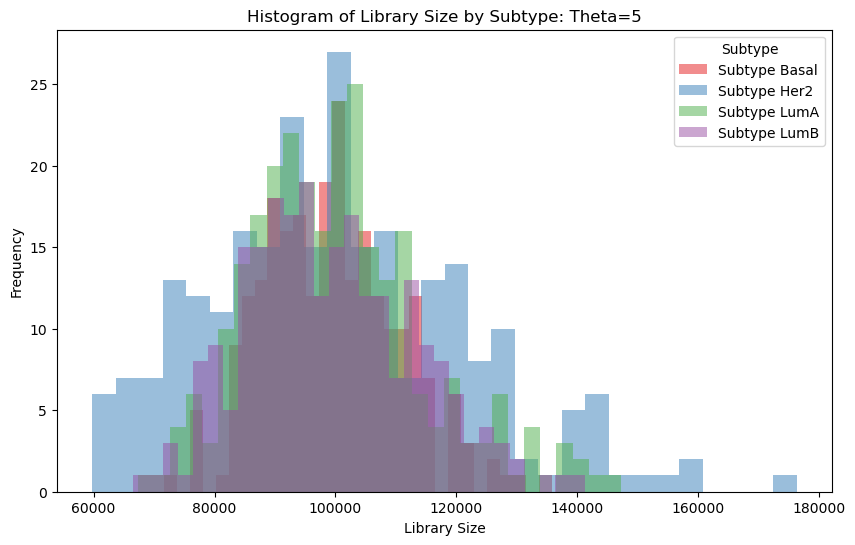

In [ ]:
# We take the results from the gamma/poisson run and create an AnnData table for PREFFECT
# add subtypes to "obs", create an adjacency matrix based on subtype
#### NOTE: Creates just 1 dataset for now, so currently set to be training ####

subtype_info = df.iloc[:, 0]

# Extract the numerical data
gamma_count_data = df.iloc[:, 1:]


adata = ad.AnnData(X=gamma_count_data.values)

# save gene names and omegas
adata.var_names = gamma_count_data.columns.values
adata.var['gene'] = adata.var_names
adata.var['her2_omega'] = [t[1] for t in vector_of_omegas['Her2']]
adata.var['basal_omega'] = [t[1] for t in vector_of_omegas['Basal']]
adata.var['luma_omega'] = [t[1] for t in vector_of_omegas['LumA']]
adata.var['lumb_omega'] = [t[1] for t in vector_of_omegas['LumB']]
adata.var['stroma_a_omega'] = [t[1] for t in omega_vector_a]
adata.var['stroma_b_omega'] = [t[1] for t in omega_vector_b]
adata.var['stroma_c_omega'] = [t[1] for t in omega_vector_c]
adata.var['stroma_d_omega'] = [t[1] for t in omega_vector_d]
adata.var['stroma_e_omega'] = [t[1] for t in omega_vector_e]


# Set variable (gene) names if they exist
sample_names = ["train_tau1_" + str(i) for i in gamma_count_data.index]
adata.obs_names = sample_names
adata.obs['subtype'] = subtype_info.values
adata.obs['stroma_type'] = stroma_subtypes

### CREATE EDGE MATRIX HERE
subtype_array = adata.obs['subtype'].to_numpy()
sample_sample_adj = (subtype_array[:, None] == subtype_array[None, :]).astype(int)

#sample_sample_adj = (adata.obs['Subtype'][:, None] == adata.obs['Subtype'][None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata.obsm['sample_sample_adj'] = sample_sample_adj_coo

# normalize library size
library_sizes = adata.X.sum(axis=1)  # Sum across columns (genes)
adjust_lib_size = False

if (adjust_lib_size):
    l_scale = 100000
    adata.X = np.round((adata.X / library_sizes[:, np.newaxis]) * l_scale)

# If we want to use this for full models, we need a sample association file
# in this instance, I know they'll be identical
sample_assocs = {
    "tau_1": sample_names,
    "tau_2": ["train_tau2_" + str(i) for i in gamma_count_data.index]
}

adata.obsm['sample_association'] = pd.DataFrame(sample_assocs, index=sample_names)


write_path = "/path/to/output/" + output_folder_name + "/train/"
adata.write(write_path + 'dataset_omega_based_PAM50_genes.train.tau_1.h5ad')


# aand again for validation
subtype_info_val = df_val.iloc[:, 0]
gamma_count_data = df_val.iloc[:, 1:]


adata_val = ad.AnnData(X=gamma_count_data.values)

# save gene names and omegas
adata_val.var_names = gamma_count_data.columns.values
adata_val.var['gene'] = adata_val.var_names
adata_val.var['her2_omega'] = [t[1] for t in vector_of_omegas['Her2']]
adata_val.var['basal_omega'] = [t[1] for t in vector_of_omegas['Basal']]
adata_val.var['luma_omega'] = [t[1] for t in vector_of_omegas['LumA']]
adata_val.var['lumb_omega'] = [t[1] for t in vector_of_omegas['LumB']]
adata_val.var['stroma_a_omega'] = [t[1] for t in omega_vector_a]
adata_val.var['stroma_b_omega'] = [t[1] for t in omega_vector_b]
adata_val.var['stroma_c_omega'] = [t[1] for t in omega_vector_c]
adata_val.var['stroma_d_omega'] = [t[1] for t in omega_vector_d]
adata_val.var['stroma_e_omega'] = [t[1] for t in omega_vector_e]

# Set variable (gene) names if they exist
sample_names = ["valid_tau1_" + str(i) for i in gamma_count_data.index]
adata_val.obs_names = sample_names
adata_val.obs['subtype'] = subtype_info_val.values
adata_val.obs['stroma_type'] = stroma_subtypes

### CREATE EDGE MATRIX HERE
subtype_array = adata_val.obs['subtype'].to_numpy()
sample_sample_adj = (subtype_array[:, None] == subtype_array[None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_val.obsm['sample_sample_adj'] = sample_sample_adj_coo

# normalize library size
library_sizes = adata_val.X.sum(axis=1)  # Sum across columns (genes)
adjust_lib_size = False

if (adjust_lib_size):
    l_scale = 100000
    adata_val.X = np.round((adata_val.X / library_sizes[:, np.newaxis]) * l_scale)

sample_assocs = {
    "tau_1": sample_names,
    "tau_2": ["valid_tau2_" + str(i) for i in gamma_count_data.index]
}

adata_val.obsm['sample_association'] = pd.DataFrame(sample_assocs, index=sample_names)


write_path = "/path/to/output/" + output_folder_name + "/validation/"
adata_val.write(write_path + 'dataset_omega_based_PAM50_genes.validation.tau_1.h5ad')

# checking to see if the library size is all ~100,000 like we want
# Create a DataFrame
df_lib = pd.DataFrame({
    'LibrarySize': library_sizes,
    'Subtype': subtype_info.values
})


# Get the list of unique subtypes
unique_subtypes = df_lib['Subtype'].unique()

# Set the figure size
plt.figure(figsize=(10, 6))

# Define colors for each subtype
colors = plt.cm.Set1(range(len(unique_subtypes)))

# Plot histograms for each subtype
for color, subtype_value in zip(colors, unique_subtypes):
    subset = df_lib[df_lib['Subtype'] == subtype_value]
    plt.hist(
        subset['LibrarySize'],
        bins=30,          # Adjust bins as needed
        alpha=0.5,        # Transparency
        label=f'Subtype {subtype_value}',
        color=color
    )

# Add labels and title
plt.xlabel('Library Size')
plt.ylabel('Frequency')
plt.title('Histogram of Library Size by Subtype: Theta=5')

# Display the legend
plt.legend(title='Subtype')

# Show the plot
plt.show()






In [20]:
def avg_expr_by_subtype(adata, var_name, subtype_col="subtype"):
    # Check that the gene (var_name) exists in adata
    if var_name not in adata.var_names:
        raise ValueError(f"Gene {var_name} not found in adata.var_names")
    
    # Check that the subtype_col exists in adata.obs
    if subtype_col not in adata.obs.columns:
        raise ValueError(f"Column {subtype_col} not found in adata.obs")
    
    # Get the expression data for the specific gene as a Series
    gene_expr = adata[:, var_name].X
    
    # Combine the gene expression and subtype annotations into a DataFrame
    df = pd.DataFrame({"expr": gene_expr.flatten(), "subtype": adata.obs[subtype_col]})
    
    # Group by subtype and calculate the mean expression
    avg_expr = df.groupby("subtype")["expr"].mean()
    
    return avg_expr

avg_expr_by_subtype(adata, "CCNB1", subtype_col="subtype")

subtype
Basal    268.203320
Her2     224.713725
LumA      93.142322
LumB     275.354430
Name: expr, dtype: float64

Create a second set of patients selected from a stickbreak algorithm, one for each subtype

In [16]:
print(omega_vector_a)
print(np.unique(stroma_subtypes))

[('EGFR', 0.003808316349011685), ('CDH3', 0.0042133113122416604), ('PHGDH', 0.003733679880595478), ('ACTR3B', 0.004340553938551319), ('FOXC1', 0.003899192016269563), ('MIA', 0.0037682537157238613), ('MYC', 0.00398360948145409), ('FGFR4', 0.004175764719617637), ('MDM2', 0.0038472772301020816), ('MLPH', 0.004026201102190241), ('KRT14', 0.0038026232036656635), ('BCL2', 0.004213765798414466), ('SFRP1', 0.004067180540299762), ('KRT5', 0.0036717912069652967), ('KRT17', 0.004090249357853233), ('SLC39A6', 0.004118578147541718), ('ESR1', 0.004239742309773264), ('CXXC5', 0.003879172339119172), ('BLVRA', 0.0037139216047699713), ('FOXA1', 0.004112094571783242), ('GPR160', 0.004105429259479597), ('NAT1', 0.004318084700911072), ('MAPT', 0.0037177318009778354), ('PGR', 0.004363537197248435), ('BAG1', 0.004096034489986176), ('TMEM45B', 0.003713511660746398), ('ERBB2', 0.0038984967114455774), ('GRB7', 0.0038130127104661652), ('MMP11', 0.004098983748825861), ('CDC20', 0.003991537274071707), ('MKI67', 0.

In [ ]:
# generate from those values
pd_columns = gene_order.copy()
pd_columns.insert(0, "stroma_type")

df_stickbreak = pd.DataFrame(columns=pd_columns)
df_stickbreak_val = pd.DataFrame(columns=pd_columns)

# stuck here. I now have stromal_subtypes, but I can't just plug it in like I did with subtype.

for i, subtype in enumerate(np.unique(stroma_subtypes)):

    pats_to_generate = np.sum(stroma_subtypes == subtype)
    print(i, subtype, pats_to_generate)


    for j in range(pats_to_generate):
        poisson_values, poisson_values_val = [], []

        for gene, mean_omega in omega_vectors[i]:
            shape_param = theta
            scale_param = (mean_omega*l)/theta
            g_i = np.random.gamma(shape=shape_param, scale=scale_param)
            
            # Generate a Poisson random variable 
            poisson_i = np.random.poisson(g_i)
            poisson_values.append(poisson_i)

            # validation set
            g_i = np.random.gamma(shape=shape_param, scale=scale_param)
            poisson_i = np.random.poisson(g_i)
            poisson_values_val.append(poisson_i)

        poisson_values.insert(0, subtype)
        poisson_values_val.insert(0, subtype)

        df_stickbreak.loc[len(df_stickbreak)] = poisson_values
        df_stickbreak_val.loc[len(df_stickbreak_val)] = poisson_values_val



0 A 122
1 B 114
2 C 230
3 D 534


In [18]:
print(df_stickbreak_val)

    stroma_type  EGFR  CDH3  PHGDH  ACTR3B  FOXC1   MIA  MYC  FGFR4  MDM2  \
0             A   281   313    146     256    296   459  464    176   705   
1             A   330   332    369     398    205  1029  362    473   149   
2             A   107   548    367     467    583   462  127    318   300   
3             A   384   541    390     217    490   584  307    699   221   
4             A   196   914    690     573    422   413  308    390   248   
..          ...   ...   ...    ...     ...    ...   ...  ...    ...   ...   
995           D   115   224    291      98    356   387  413    313   162   
996           D   149   329    543     345    373   259  278    410   975   
997           D   672   395    803     537    233   237  578     46   228   
998           D   213   466    344     438    270   225  455    492   459   
999           D   353   161    494     561    366   413  376    309   180   

     ...  gene_41  gene_42  gene_43  gene_44  gene_45  gene_46  gene_47  \


In [19]:
def reorder_dataframe(df, order_column, new_order):
    """
    Reorder the rows of a DataFrame based on a custom sequence in a specified column.

    Parameters:
    - df (pd.DataFrame): The DataFrame to reorder.
    - order_column (str): The name of the column to reorder by.
    - new_order (list): The desired sequence of values in the order_column.

    Returns:
    - pd.DataFrame: The reordered DataFrame.
    """
    # Count the available rows for each value in the order_column
    value_counts = df[order_column].value_counts().to_dict()
    
    # Group the DataFrame by the order_column
    grouped = df.groupby(order_column)
    
    # Initialize indices to track which rows have been used
    indices = {val: 0 for val in value_counts.keys()}
    
    # Create a dictionary of DataFrames for each group
    group_dfs = {val: group.reset_index(drop=True) for val, group in grouped}
    
    # List to hold the reordered rows
    reordered_rows = []
    
    # Build the reordered rows based on new_order
    for val in new_order:
        if indices[val] < value_counts[val]:
            # Get the next unused row for this value
            row = group_dfs[val].iloc[indices[val]]
            reordered_rows.append(row)
            indices[val] += 1
        else:
            # Handle the case where there are not enough rows
            raise ValueError(f"Not enough rows in the DataFrame for '{val}' to match the new_order.")
    
    # Create a DataFrame from the reordered rows
    reordered_df = pd.DataFrame(reordered_rows)
    
    # Append any remaining rows that were not used
    for val in value_counts.keys():
        remaining = value_counts[val] - indices[val]
        if remaining > 0:
            remaining_rows = group_dfs[val].iloc[indices[val]:]
            reordered_df = pd.concat([reordered_df, remaining_rows], ignore_index=True)
    
    return reordered_df

In [ ]:
# right now df_stickbreak_val is in sequential order. How do we re-order it to meet stroma_subtypes order?

df_reordered = reorder_dataframe(df_stickbreak, 'stroma_type', stroma_subtypes)
df_reordered.index = df.index

df_reordered_val = reorder_dataframe(df_stickbreak_val, 'stroma_type', stroma_subtypes)
df_reordered_val.index = df_val.index


print(df_reordered)

    stroma_type  EGFR  CDH3  PHGDH  ACTR3B  FOXC1  MIA  MYC  FGFR4  MDM2  ...  \
0             B   401   604    486     224    426  164  297    497   339  ...   
1             B   304   343    296     190    358  190  368    217   765  ...   
2             B   209   602    555     694    246  393  643    392   266  ...   
3             B   338   239    415     349    548  206  513    344   453  ...   
4             B   293   402    650     330    469  424  250    805   424  ...   
..          ...   ...   ...    ...     ...    ...  ...  ...    ...   ...  ...   
995           D   670   470    886     503    293  369  481    398   809  ...   
996           D   214   611    126     286    154  392  351    237   166  ...   
997           D   392   152    703     430    339  806  268    390   325  ...   
998           D   231   713    286     388    401  296  226    935   678  ...   
999           D   592   387    121     214    631  231  553    520   454  ...   

     gene_41  gene_42  gene

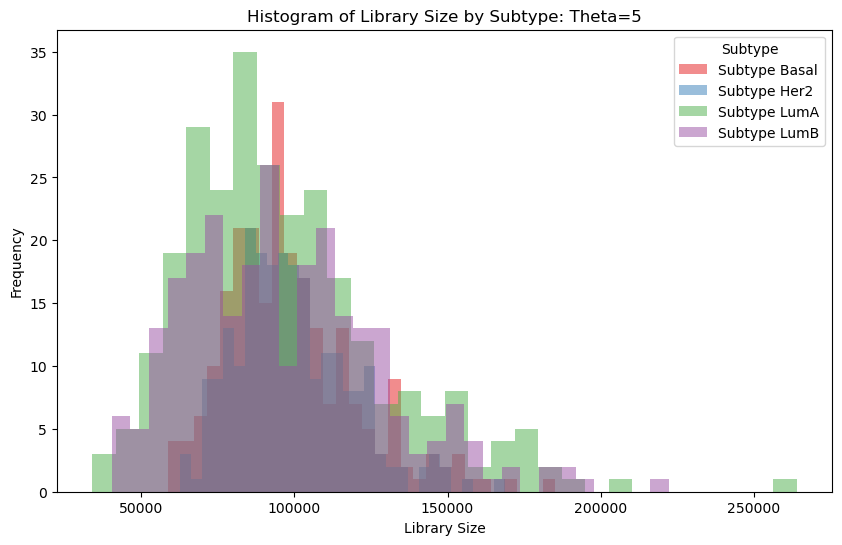

In [ ]:

# Extract the numerical data
gamma_count_data = df_reordered.iloc[:, 1:]


adata = ad.AnnData(X=gamma_count_data.values)

# save gene names and omegas
adata.var_names = gamma_count_data.columns.values
adata.var['gene'] = adata.var_names
adata.var['her2_omega'] = [t[1] for t in vector_of_omegas['Her2']]
adata.var['basal_omega'] = [t[1] for t in vector_of_omegas['Basal']]
adata.var['luma_omega'] = [t[1] for t in vector_of_omegas['LumA']]
adata.var['lumb_omega'] = [t[1] for t in vector_of_omegas['LumB']]
adata.var['stroma_a_omega'] = [t[1] for t in omega_vector_a]
adata.var['stroma_b_omega'] = [t[1] for t in omega_vector_b]
adata.var['stroma_c_omega'] = [t[1] for t in omega_vector_c]
adata.var['stroma_d_omega'] = [t[1] for t in omega_vector_d]
adata.var['stroma_e_omega'] = [t[1] for t in omega_vector_e]



# Set variable (gene) names if they exist
sample_names = ["train_tau2_" + str(i) for i in gamma_count_data.index]
adata.obs_names = sample_names
adata.obs['subtype'] = subtype_info.values
adata.obs['stroma_type'] = stroma_subtypes

### CREATE EDGE MATRIX HERE
subtype_array = adata.obs['subtype'].to_numpy()
sample_sample_adj = (subtype_array[:, None] == subtype_array[None, :]).astype(int)

#sample_sample_adj = (adata.obs['Subtype'][:, None] == adata.obs['Subtype'][None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata.obsm['sample_sample_adj'] = sample_sample_adj_coo



# normalize library size if desired
library_sizes = adata.X.sum(axis=1)  # Sum across columns (genes)
adjust_lib_size = False

if (adjust_lib_size):
    l_scale = 100000
    adata.X = np.round((adata.X / library_sizes[:, np.newaxis]) * l_scale)

sample_assocs = {
    "tau_1": ["train_tau1_" + str(i) for i in gamma_count_data.index],
    "tau_2": sample_names   
}

adata.obsm['sample_association'] = pd.DataFrame(sample_assocs, index=sample_names)

write_path = "/path/to/output/" + output_folder_name + "/train/"
adata.write(write_path + 'dataset_omega_based_PAM50_genes.train.tau_2.h5ad')

# and validation


gamma_count_data = df_reordered_val.iloc[:, 1:]
adata_val = ad.AnnData(X=gamma_count_data.values)

adata_val.var_names = gamma_count_data.columns.values
adata_val.var['gene'] = adata_val.var_names
adata_val.var['her2_omega'] = [t[1] for t in vector_of_omegas['Her2']]
adata_val.var['basal_omega'] = [t[1] for t in vector_of_omegas['Basal']]
adata_val.var['luma_omega'] = [t[1] for t in vector_of_omegas['LumA']]
adata_val.var['lumb_omega'] = [t[1] for t in vector_of_omegas['LumB']]
adata_val.var['stroma_a_omega'] = [t[1] for t in omega_vector_a]
adata_val.var['stroma_b_omega'] = [t[1] for t in omega_vector_b]
adata_val.var['stroma_c_omega'] = [t[1] for t in omega_vector_c]
adata_val.var['stroma_d_omega'] = [t[1] for t in omega_vector_d]
adata_val.var['stroma_e_omega'] = [t[1] for t in omega_vector_e]

# Set variable (gene) names if they exist
sample_names = ["valid_tau2_" + str(i) for i in gamma_count_data.index]
adata_val.obs_names = sample_names
adata_val.obs['subtype'] = subtype_info_val.values
adata_val.obs['stroma_type'] = stroma_subtypes

### CREATE EDGE MATRIX HERE
subtype_array = adata_val.obs['subtype'].to_numpy()
sample_sample_adj = (subtype_array[:, None] == subtype_array[None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_val.obsm['sample_sample_adj'] = sample_sample_adj_coo



# normalize library size if desired
library_sizes = adata_val.X.sum(axis=1)  # Sum across columns (genes)
adjust_lib_size = False

if (adjust_lib_size):
    l_scale = 100000
    adata_val.X = np.round((adata_val.X / library_sizes[:, np.newaxis]) * l_scale)

sample_assocs = {
    "tau_1": ["valid_tau1_" + str(i) for i in gamma_count_data.index],
    "tau_2": sample_names   
}

adata_val.obsm['sample_association'] = pd.DataFrame(sample_assocs, index=sample_names)

write_path = "/path/to/output/" + output_folder_name + "/validation/"
adata_val.write(write_path + 'dataset_omega_based_PAM50_genes.validation.tau_2.h5ad')


# Create a DataFrame
df_plot = pd.DataFrame({
    'LibrarySize': library_sizes,
    'Subtype': subtype_info.values
})

# Get the list of unique subtypes
unique_subtypes = df_plot['Subtype'].unique()

# Set the figure size
plt.figure(figsize=(10, 6))

# Define colors for each subtype
colors = plt.cm.Set1(range(len(unique_subtypes)))

# Plot histograms for each subtype
for color, subtype_value in zip(colors, unique_subtypes):
    subset = df_plot[df_plot['Subtype'] == subtype_value]
    plt.hist(
        subset['LibrarySize'],
        bins=30,          # Adjust bins as needed
        alpha=0.5,        # Transparency
        label=f'Subtype {subtype_value}',
        color=color
    )

# Add labels and title
plt.xlabel('Library Size')
plt.ylabel('Frequency')
plt.title('Histogram of Library Size by Subtype: Theta=5')

# Display the legend
plt.legend(title='Subtype')

# Show the plot
plt.show()

In [22]:
print(adata.obs)
print(adata.obs["stroma_type"].value_counts())

               subtype stroma_type
train_tau2_0     Basal           B
train_tau2_1     Basal           B
train_tau2_2     Basal           B
train_tau2_3     Basal           B
train_tau2_4     Basal           B
...                ...         ...
train_tau2_995    LumB           D
train_tau2_996    LumB           D
train_tau2_997    LumB           D
train_tau2_998    LumB           D
train_tau2_999    LumB           D

[1000 rows x 2 columns]
D    534
C    230
A    122
B    114
Name: stroma_type, dtype: int64
